In [1]:
do_data_cdf = "results/doxg.nc"
do_variables = ['controlDOXG', 'c2936DOXG',
                'q1c454DOXG', 'q1c15DOXG', 'q1c2936DOXG',
                'q3c454DOXG', 'q3c10DOXG', 'q3c15DOXG', 'q3c20DOXG', 'q3c25DOXG', 'q3c2936DOXG',
                'q5c454DOXG', 'q5c10DOXG', 'q5c15DOXG', 'q5c20DOXG', 'q5c25DOXG', 'q5c2936DOXG',
                'q7c454DOXG', 'q7c10DOXG', 'q7c15DOXG', 'q7c20DOXG', 'q7c25DOXG', 'q7c2936DOXG',
                'q9c454DOXG', 'q9c10DOXG', 'q9c15DOXG', 'q9c20DOXG', 'q9c25DOXG', 'q9c2936DOXG']
control_variable = 'control'
variable_type = 'DOXG'
out_path = "results/hypoxvol/"

start_date = None

from pathlib import Path

SSM_ANALYSIS = Path('/home/benr/src/ssm-analysis')
grid_file = SSM_ANALYSIS / 'SSM_Grid/ssm_grid.2dm'

import os.path as path
import os
from netCDF4 import Dataset
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import cmocean
from adjustText import adjust_text

from fvcom.grid import FvcomGrid
from fvcom.depth import DepthCoordinate
from fvcom.control_volume import ControlVolume, StationHelper

In [2]:
do_data = Dataset(do_data_cdf)
do_data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    model_start: 2014-01-01 00:00:00
    dimensions(sizes): time(4380), node(3137), nele(4129), siglay(10), siglev(11)
    variables(dimensions): int32 node(node), float32 h(node), float32 x(node), float32 y(node), int32 nele(nele), float32 time(time), float32 siglay(siglay), float32 siglev(siglev), float32 zeta(time, node), float32 controlDOXG(time, siglay, node), float32 c2936DOXG(time, siglay, node), float32 q5c2936DOXG(time, siglay, node), float32 q5c454DOXG(time, siglay, node), float32 q1c454DOXG(time, siglay, node), float32 q1c2936DOXG(time, siglay, node), float32 q5c15DOXG(time, siglay, node), float32 q9c454DOXG(time, siglay, node), float32 q9c2936DOXG(time, siglay, node), float32 q1c15DOXG(time, siglay, node), float32 q3c454DOXG(time, siglay, node), float32 q3c15DOXG(time, siglay, node), float32 q3c2936DOXG(time, siglay, node), float32 q5c10DOXG(time, siglay, node), float32 q5c20DOXG(time, sig

In [3]:
if 'model_start' in do_data.ncattrs():
    start_date = pd.Timestamp(do_data.model_start)
    display(f'Model start date is {start_date}')
else:
    start_date = pd.Timestamp(start_date)
timestep = do_data['time'][2] - do_data['time'][1]
timestep

'Model start date is 2014-01-01 00:00:00'

0.08333333

In [4]:
if type(do_variables) == str:
    do_variables = (do_variables,)
control_variable += variable_type if not control_variable.endswith(variable_type) else ''
do_variables = [v + (variable_type if not v.endswith(variable_type) else '') for v in do_variables]
assert control_variable in do_variables, f"Control variable '{control_variable}' should be present in do_variables."

In [5]:
out_base = Path(do_data_cdf).stem
if not path.isdir(out_path):
    os.mkdir(out_path)
out_file = lambda name: path.join(out_path, out_base + "_fulldo_" + name)

In [6]:
do_variable_titles = [s.removesuffix(variable_type) for s in do_variables]
control_title = control_variable.removesuffix(variable_type)
do_variable_titles

['control',
 'c2936',
 'q1c454',
 'q1c15',
 'q1c2936',
 'q3c454',
 'q3c10',
 'q3c15',
 'q3c20',
 'q3c25',
 'q3c2936',
 'q5c454',
 'q5c10',
 'q5c15',
 'q5c20',
 'q5c25',
 'q5c2936',
 'q7c454',
 'q7c10',
 'q7c15',
 'q7c20',
 'q7c25',
 'q7c2936',
 'q9c454',
 'q9c10',
 'q9c15',
 'q9c20',
 'q9c25',
 'q9c2936']

<Axes: >

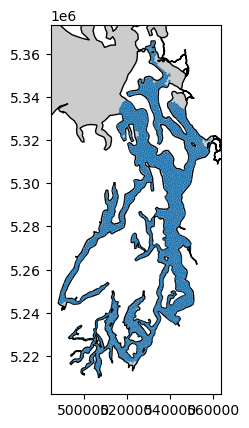

In [7]:
grid = FvcomGrid.from_mesh(grid_file)
cv = ControlVolume(grid=grid, nodes=set(do_data['node'][:]), calc=True)
dcoord = DepthCoordinate.from_output(do_data, grid=grid)
domain = cv.tces
cv.plot()

In [8]:
times = do_data['time'][:]
dates = start_date + pd.to_timedelta(times, 'd')
# get siglev thickness at each node, use to calculate volume of each cell
grid3d = np.expand_dims(dcoord.dz, 1) @ np.expand_dims(do_data['h'], 0)
# cell volume in m3
cellvols = grid3d * domain.area.to_numpy()
# Total volume in km3
total_volume = cellvols.sum() / 1e9
total_volume_2 = np.expand_dims(domain.area.to_numpy(), 0) @ np.expand_dims(do_data['h'], 1) / 1e9
assert (total_volume - total_volume_2) / total_volume < 0.0001, f"{total_volume} != {total_volume_2}"

def extract_data(var):
    return do_data[var][:].data

# Calculate the total time that this retrieved node index spent with a hypoxic DO
def calc_duration(data, i):
    return (np.count_nonzero(data[:,:,i] < 2) * timestep).min(axis=1)

def calc_volume(data, t):
    return cellvols[data[t,:,:] < 2].sum() / 1e9

extracted_data = {}
hypoxic_volumes = {}

for v in do_variables:
    extracted_data[v] = extract_data(v)
    hypoxic_volumes[v] = np.zeros(extracted_data[v].shape[0])
    for t in range(len(hypoxic_volumes[v])):
        hypoxic_volumes[v][t] = calc_volume(extracted_data[v], t)

hypoxic_volumes_df = pd.DataFrame(hypoxic_volumes, index=dates)

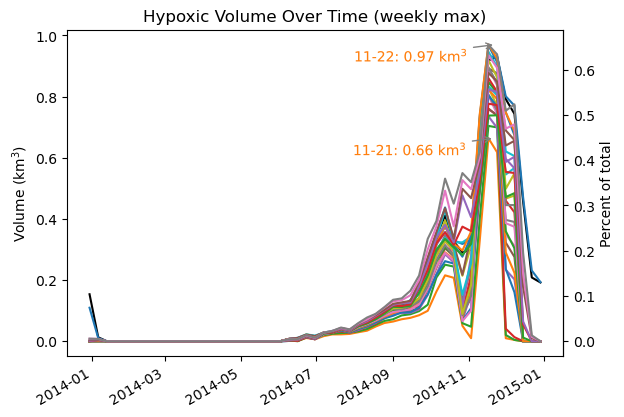

In [9]:
fig, ax = plt.subplots()
hypoxic_volumes_weekly = hypoxic_volumes_df.groupby(hypoxic_volumes_df.index.to_period('W')).max()
hypoxic_volumes_weekly.set_index(hypoxic_volumes_weekly.index.to_timestamp('D', 's'), inplace=True)
texts = []
all_maxvals = hypoxic_volumes_df.max()
for v, t in zip(do_variables, do_variable_titles):
    if t == control_title:
        color = 'black'
    else:
        color = None
    l = ax.plot(hypoxic_volumes_weekly[v], color=color, label=t)
    mx = hypoxic_volumes_df[v].idxmax()
    mxv = hypoxic_volumes_df.loc[mx, v]
    if mxv == np.max(all_maxvals) or mxv == np.min(all_maxvals):
        tx = ax.annotate(f"{mx.strftime('%m-%d')}: {mxv:.2f} km$^3$",
                         xy=(mx, hypoxic_volumes_df.loc[mx, v]), color=l[0].get_color(),
                         xytext=(-20, -1), textcoords='offset points',
                         ha='right', va='top',
                         arrowprops={'arrowstyle': '->', 'color': 'gray'},
                         path_effects=[pe.withStroke(linewidth=3,
                                                     foreground='white', alpha=0.6)])
        texts.append(tx)
ax.set(title="Hypoxic Volume Over Time (weekly max)", ylabel="Volume (km$^3$)")
fig.autofmt_xdate()
#ax.legend()
#adjust_text(texts, ax=ax)

# Build a secondary y-axis with the total volume percentage
def vol_to_pct(a):
    return a * 100 / total_volume
def pct_to_vol(p):
    return p / 100 * total_volume

secax = ax.secondary_yaxis('right', functions=(vol_to_pct, pct_to_vol))
secax.set_ylabel("Percent of total")
fig.savefig(out_file("hypoxic_volume.png"))
hypoxic_volumes_df.to_excel(out_file("hypoxic_volume.xlsx"))

In [15]:
do_data.close()

RuntimeError: NetCDF: Not a valid ID